# LoC batch quantification notebook

Assess the number of cells expressing above a thresholded value of certain markers

1. Assess results from previous thresholding
2. Quantify based on manually chosen thresholds

In [136]:
import os # for filename manipulations
import glob # for more fn operations 
import pandas as pd # module for data org 
import matplotlib.pyplot as plt # module for plotting
import seaborn as sns # module for plotting
import numpy as np # for math operations
from scipy.stats import ttest_ind # automatically determining threshold using t test
from scipy.stats import ks_2samp # automatically determining threshold using kolmogorov smirnov test
from tqdm.auto import tqdm # prgress bar
sns.set(font='Nimbus Sans', style = 'white') # my favourite formatting :)
sns.set_palette('PiYG') # my favourite colours :D 

## 1. Load previous assessment of positive/negative cells

Check which specific experiments to do in previous job file

In [4]:
input_file = "/home/dayn/data/homuncu_loc_temp/job_1a_files.txt"
with open(input_file, "r") as file:
    job1a_files = [line.strip() for line in file]
print('\n'.join(job1a_files))

DAPI-SPC-PDPN-ZO1/Day14_breath/20x_21-12-029B_A12346_Multichannel Z-Stack_20220819_295.tif
DAPI-SPC-PDPN-ZO1/Day14_static/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_246.tif
DAPI-SPC-PDPN-ZO1/Day7_breath/20x_21-12-029A_A3456_Multichannel Z-Stack_20220818_196.tif
DAPI-SPC-PDPN-ZO1/Day7_static/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_121.tif
DAPI-NKX21-PDPN-ZO1/Day14_breath/20x_21-12-029B_A12346_Multichannel Z-Stack_20220819_286.tif
DAPI-NKX21-PDPN-ZO1/Day14_static/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_235.tif
DAPI-NKX21-PDPN-ZO1/Day7_static/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_113.tif


Load csv files

In [8]:
local_rootdir = '/home/dayn/data/homuncu_loc_temp/'
pixel_value_files = []
for root, _, files in os.walk(local_rootdir):
    for file in files:
        if file.lower().endswith('.csv'):
            pixel_value_files.append(os.path.join(root, file))
# Display the list of CSV file paths
print('\n'.join(pixel_value_files)

/home/dayn/data/homuncu_loc_temp/DAPI-NKX21-PDPN-ZO1/Day14_breath/286_ch1_positive_details.csv
/home/dayn/data/homuncu_loc_temp/DAPI-NKX21-PDPN-ZO1/Day14_breath/286_ch1_negative_details.csv
/home/dayn/data/homuncu_loc_temp/DAPI-NKX21-PDPN-ZO1/Day14_static/235_ch1_positive_details.csv
/home/dayn/data/homuncu_loc_temp/DAPI-NKX21-PDPN-ZO1/Day14_static/235_ch1_negative_details.csv
/home/dayn/data/homuncu_loc_temp/DAPI-NKX21-PDPN-ZO1/Day7_static/113_ch1_negative_details.csv
/home/dayn/data/homuncu_loc_temp/DAPI-NKX21-PDPN-ZO1/Day7_static/113_ch1_positive_details.csv
/home/dayn/data/homuncu_loc_temp/DAPI-SPC-PDPN-ZO1/Day14_breath/295_segmentation_needs_revisiting.csv
/home/dayn/data/homuncu_loc_temp/DAPI-SPC-PDPN-ZO1/Day7_breath/196_ch1_positive_details.csv
/home/dayn/data/homuncu_loc_temp/DAPI-SPC-PDPN-ZO1/Day7_breath/196_ch2_negative_details.csv
/home/dayn/data/homuncu_loc_temp/DAPI-SPC-PDPN-ZO1/Day7_breath/196_ch1_negative_details.csv
/home/dayn/data/homuncu_loc_temp/DAPI-SPC-PDPN-ZO1/Day

In [226]:
len(pixel_value_files)

19

Collate all pixel info into one df

In [81]:
dfs = list()
for fn in pixel_value_files:
    if 'revisiting' in fn:
        continue
    # get details of particular expt
    fn_details = fn.split(local_rootdir)[-1]
    day_detail = fn_details.split('/')[1]
    image_ID = fn_details.split('/')[-1].split('_')[0]
    channels = [ch for ch in fn_details.split('/')[0].split('-')]
    marker_status = 'positive' if 'positive' in fn else 'negative'
    # load values and annotate into df
    df = pd.read_csv(fn, names=["cell ID", "z slice", "Mean Pixel Intensity"]).replace(r'\(|\)', '', regex=True)
    df = df.apply(pd.to_numeric, errors='coerce')
    df['marker status'] = marker_status
    df['channel'] = channels[1] if 'ch1' in fn else channels[2]
    df['day'] = day_detail
    df['image_id'] = image_ID
    dfs.append(df)
df = pd.concat(dfs, axis = 0)

In [238]:
df[df['image_id'] == '121']['channel'].unique()

array(['SPC', 'PDPN'], dtype=object)

# 2. Plot 

(0.0, 26.25)


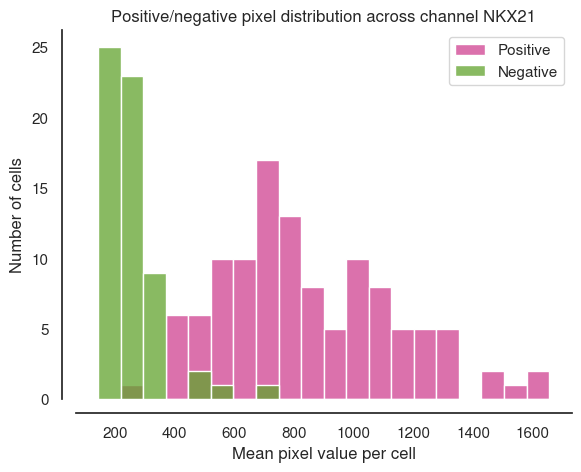

In [157]:
### set channel and day
day = 'Day14_breath'
channel = 'NKX21'
# Select data for positive and negative marker status
positive_data = df[(df['channel'] == channel) &
                   (df['marker status'] == 'positive') &
                   (df['day'] == day)]['Mean Pixel Intensity']
negative_data = df[(df['channel'] == channel) &
                   (df['marker status'] == 'negative') &
                   (df['day'] == day)]['Mean Pixel Intensity']

# Determine the common bin edges based on the combined data range
combined_data = pd.concat([positive_data, negative_data])
data_min = combined_data.min()
data_max = combined_data.max()
n_bins = 20  # Number of bins

bin_edges = np.linspace(data_min, data_max, n_bins + 1)

# Plot the histograms with the same bin width
sns.histplot(data=positive_data, bins=bin_edges, color=sns.color_palette('PiYG')[0], label='Positive')
sns.histplot(data=negative_data, bins=bin_edges, color=sns.color_palette('PiYG')[-1], label='Negative')

sns.despine(offset=10)
plt.xlabel('Mean pixel value per cell')
plt.ylabel('Number of cells')
plt.title(f'Positive/negative pixel distribution across channel NKX21')
plt.legend()
plt.show()


Defining threshold between the two populations of data using 
## Kolmogorov-Smirnov Test:
The Kolmogorov-Smirnov test is a non-parametric test and makes no assumptions about the underlying distribution of the data.
It tests whether two distributions are significantly different from each other, without assuming any specific distribution shape.
The Kolmogorov-Smirnov test is more robust against departures from normality and can detect differences in distributions even if the underlying data is not normally distributed.
It is particularly useful when the distributions have different shapes or if the data is heavily skewed or contains outliers.


In [159]:
# Define the significance level (alpha)
alpha = 0.05

### Batch plot with threshold

In [284]:
subset_df = df[(df['image_id'] == '246')]

In [269]:
subset_df

,cell ID,z slice,Mean Pixel Intensity,marker status,channel,day,image_id
0,7530,30.0,1030.71620,negative,SPC,Day14_static,246
1,7551,30.0,669.05180,negative,SPC,Day14_static,246
2,7551,30.0,669.05180,negative,SPC,Day14_static,246
3,7618,30.0,538.20360,negative,SPC,Day14_static,246
4,980,30.0,1173.68480,negative,SPC,Day14_static,246
...,...,...,...,...,...,...,...
41,9886,31.0,590.30090,negative,PDPN,Day14_static,246
42,9832,31.0,542.85150,negative,PDPN,Day14_static,246
43,4772,31.0,515.39246,negative,PDPN,Day14_static,246
44,9841,31.0,584.56890,negative,PDPN,Day14_static,246


In [285]:
channels = subset_df['channel'].unique()

In [286]:
channels

array(['SPC', 'PDPN'], dtype=object)

In [287]:
channel

'PDPN'

In [288]:
subset_df['channel'] == channel

0     False
1     False
2     False
3     False
4     False
      ...  
41     True
42     True
43     True
44     True
45     True
Name: channel, Length: 217, dtype: bool

In [289]:
subset_df[(subset_df['channel'] == channel)]

,cell ID,z slice,Mean Pixel Intensity,marker status,channel,day,image_id
0,10055,31.0,1679.51460,positive,PDPN,Day14_static,246
1,4993,31.0,1631.57230,positive,PDPN,Day14_static,246
2,589,31.0,1765.75200,positive,PDPN,Day14_static,246
3,5279,31.0,2079.45000,positive,PDPN,Day14_static,246
4,8569,31.0,1236.11670,positive,PDPN,Day14_static,246
...,...,...,...,...,...,...,...
41,9886,31.0,590.30090,negative,PDPN,Day14_static,246
42,9832,31.0,542.85150,negative,PDPN,Day14_static,246
43,4772,31.0,515.39246,negative,PDPN,Day14_static,246
44,9841,31.0,584.56890,negative,PDPN,Day14_static,246


In [263]:
channels

array(['SPC', 'PDPN'], dtype=object)

In [290]:
for channel in channels:#
    # further refine dataframe to one channel
    test = subset_df[(subset_df['channel'] == channel)]
    if test.empty:
            print(channel)

In [266]:
subset_df

,cell ID,z slice,Mean Pixel Intensity,marker status,channel,day,image_id


non empty:('DAPI-SPC-PDPN-ZO1/Day14_static/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_246.tif', 'SPC')
The Kolmogorov-Smirnov test indicates a significant difference between the groups (p-value:0.00)
The threshold based on the Kolmogorov-Smirnov test is: 1644.01


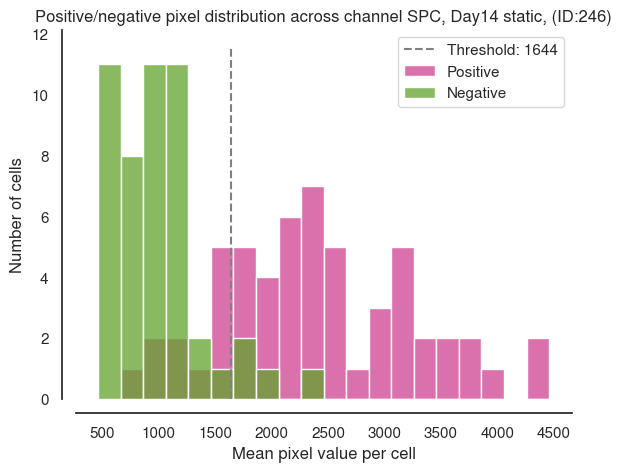

non empty:('DAPI-SPC-PDPN-ZO1/Day14_static/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_246.tif', 'PDPN')
The Kolmogorov-Smirnov test indicates a significant difference between the groups (p-value:0.00)
The threshold based on the Kolmogorov-Smirnov test is: 1031.84


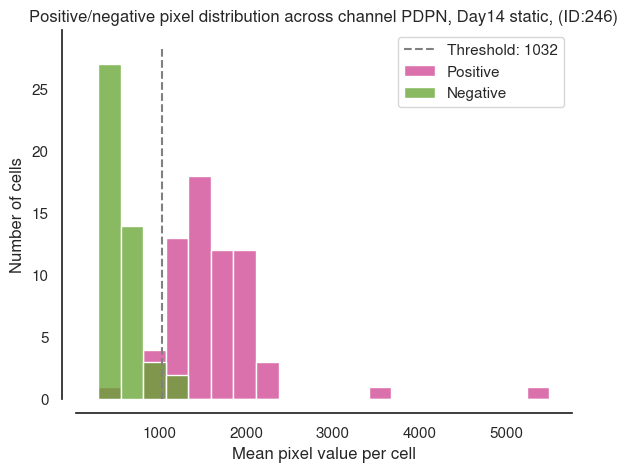

non empty:('DAPI-SPC-PDPN-ZO1/Day7_breath/20x_21-12-029A_A3456_Multichannel Z-Stack_20220818_196.tif', 'SPC')
The Kolmogorov-Smirnov test indicates a significant difference between the groups (p-value:0.00)
The threshold based on the Kolmogorov-Smirnov test is: 985.47


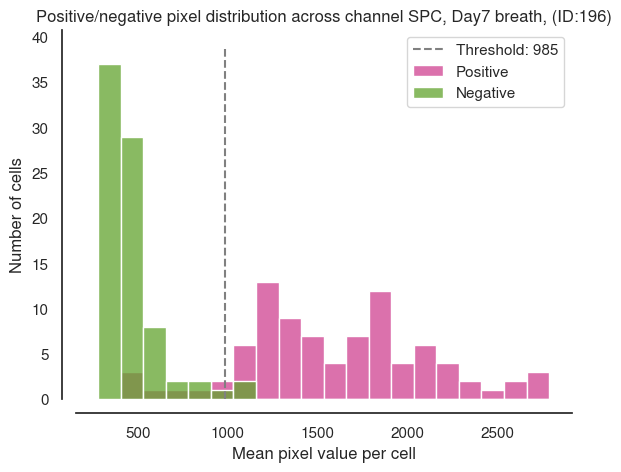

non empty:('DAPI-SPC-PDPN-ZO1/Day7_breath/20x_21-12-029A_A3456_Multichannel Z-Stack_20220818_196.tif', 'PDPN')
The Kolmogorov-Smirnov test indicates a significant difference between the groups (p-value:0.00)
The threshold based on the Kolmogorov-Smirnov test is: 991.97


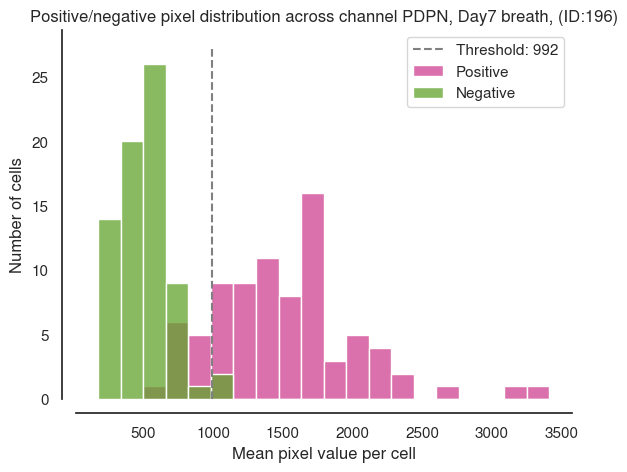

non empty:('DAPI-SPC-PDPN-ZO1/Day7_static/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_121.tif', 'SPC')
The Kolmogorov-Smirnov test indicates a significant difference between the groups (p-value:0.00)
The threshold based on the Kolmogorov-Smirnov test is: 583.03


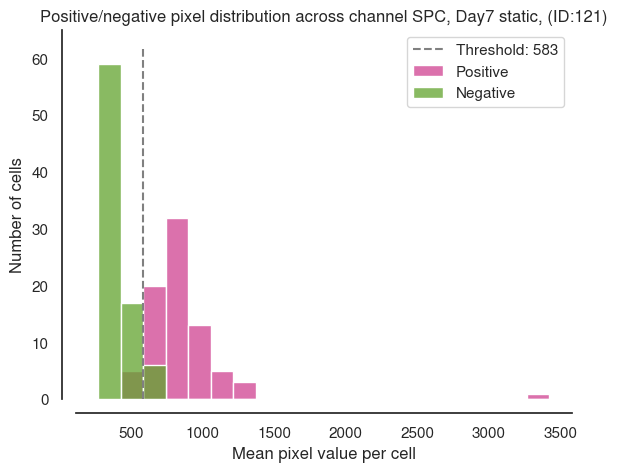

non empty:('DAPI-SPC-PDPN-ZO1/Day7_static/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_121.tif', 'PDPN')
The Kolmogorov-Smirnov test indicates a significant difference between the groups (p-value:0.00)
The threshold based on the Kolmogorov-Smirnov test is: 447.21


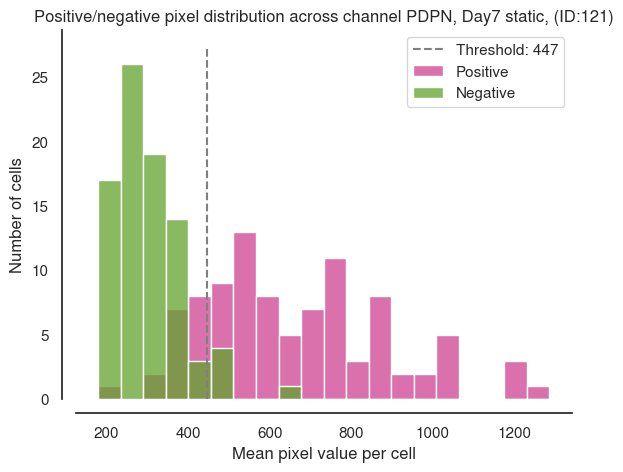

non empty:('DAPI-NKX21-PDPN-ZO1/Day14_breath/20x_21-12-029B_A12346_Multichannel Z-Stack_20220819_286.tif', 'NKX21')
The Kolmogorov-Smirnov test indicates a significant difference between the groups (p-value:0.00)
The threshold based on the Kolmogorov-Smirnov test is: 512.65


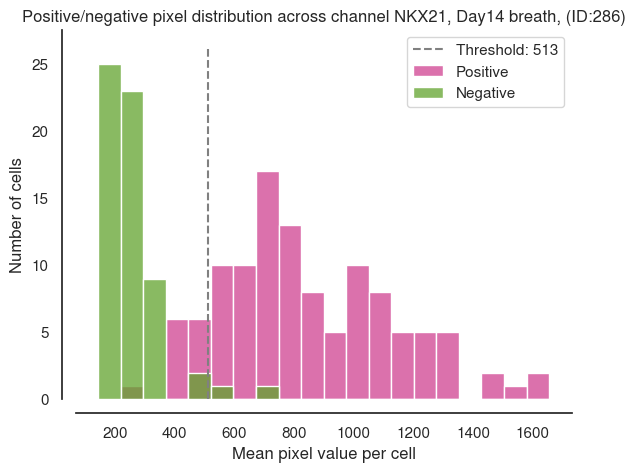

non empty:('DAPI-NKX21-PDPN-ZO1/Day14_static/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_235.tif', 'NKX21')
The Kolmogorov-Smirnov test indicates a significant difference between the groups (p-value:0.00)
The threshold based on the Kolmogorov-Smirnov test is: 1252.30


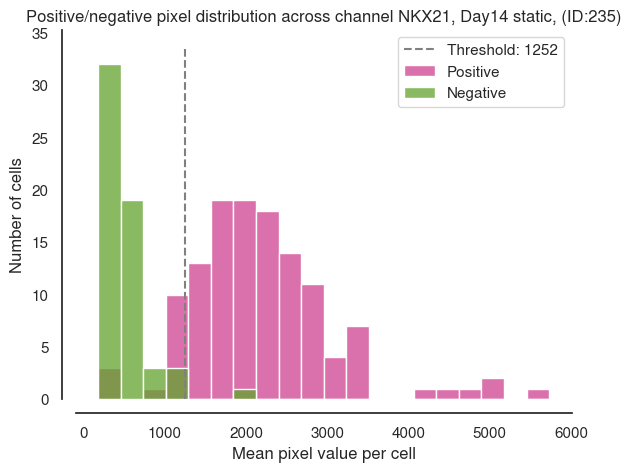

non empty:('DAPI-NKX21-PDPN-ZO1/Day7_static/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_113.tif', 'NKX21')
The Kolmogorov-Smirnov test indicates a significant difference between the groups (p-value:0.00)
The threshold based on the Kolmogorov-Smirnov test is: 380.14


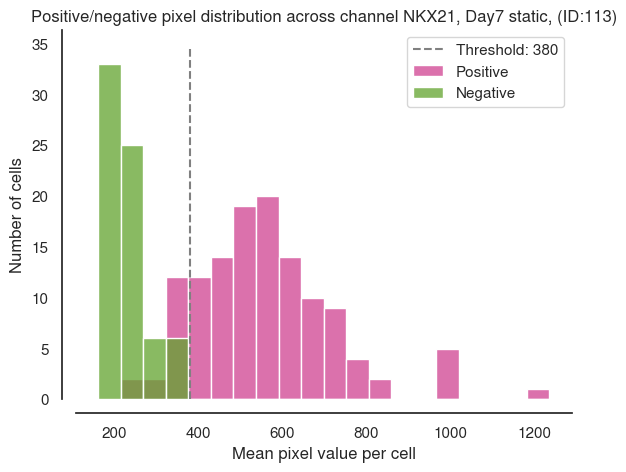

<Figure size 640x480 with 0 Axes>

In [296]:
counter = 0
threshold_dict = dict()
for fn in job1a_files:
    # get image id from filename
    image_id = fn.split('.')[0].split('_')[-1]
    # extract only this images measurements from main df
    subset_df = df[(df['image_id'] == image_id)]
    # some images dont have data associated (yet)
    if subset_df.empty:
        continue
    # extract channels available for this position
    channels = subset_df['channel'].unique()
    for channel in channels:
        # further refine dataframe to one channel
        subsubset_df = subset_df[(subset_df['channel'] == channel)]
        # some images dont have channel data (yet)
        if subset_df.empty:
            print(f'empty:{fn, channel}')
            continue
        else:
            print(f'non empty:{fn, channel}')
#         set day
        day = subsubset_df['day'].iloc[0]
        # Select data for positive and negative marker status
        positive_data = subsubset_df[subsubset_df['marker status'] == 'positive']['Mean Pixel Intensity']
        negative_data = subsubset_df[subsubset_df['marker status'] == 'negative']['Mean Pixel Intensity']
        # Determine the common bin edges based on the combined data range
        combined_data = pd.concat([positive_data, negative_data])
        data_min = combined_data.min()
        data_max = combined_data.max()
        n_bins = 20  # Number of bins
        bin_edges = np.linspace(data_min, data_max, n_bins + 1)
        # Plot the histograms with the same bin width
        sns.histplot(data=positive_data, bins=bin_edges, color=sns.color_palette('PiYG')[0], label='Positive')
        sns.histplot(data=negative_data, bins=bin_edges, color=sns.color_palette('PiYG')[-1], label='Negative')
        # check if two datasets are statistically significant using two different tests
        statistic_ks, p_value_ks = ks_2samp(positive_data, negative_data)

        # Check if the p-value from the Kolmogorov-Smirnov test is less than the significance level
        if p_value_ks < alpha:
            threshold_ks = (positive_data.median() + negative_data.median()) / 2
            print(f"The Kolmogorov-Smirnov test indicates a significant difference between the groups (p-value:{p_value_ks:.2f})")
            print(f"The threshold based on the Kolmogorov-Smirnov test is: {threshold_ks:.2f}")
        else:
            print("The Kolmogorov-Smirnov test does not indicate a significant difference between the groups.")
            print("Threshold determination based on Kolmogorov-Smirnov test is not recommended.")

        # ttest
        #     t_statistic, p_value_ttest = ttest_ind(positive_data, negative_data)
        #     # choose which stat to plot
        #     statistic, p_value = statistic_ks, p_value_ks

        #     # Check if the p-value from the t-test is less than the significance level
        #     if p_value_ttest < alpha:
        #         threshold_ttest = (positive_data.mean() + negative_data.mean()) / 2
        #         print(f"The t-test indicates a significant difference between the groups (p-value:{p_value_ttest:.2f})")
        #         print(f"The threshold based on the t-test is: {threshold_ttest:.2f}")
        #     else:
        #         print(f"The t-test does not indicate a significant difference between the groups (p-value:{p_value_ttest:.2f})")
        #         print("Threshold determination based on t-test is not recommended.")

        # format plot
        sns.despine(offset=10)
        plt.xlabel('Mean pixel value per cell')
        plt.ylabel('Number of cells')

        # plot threshold on graph 
        plt.vlines(x = threshold_ks, 
                   ymax=plt.ylim()[-1], 
                   ymin=0, 
                   colors='gray', linestyles='dashed', label = f'Threshold: {threshold_ks:.0f}')

            # plot p values on graph?
        #     if p_value < alpha:
        #         text = f'These two distributions are\n statistically significant \n(p-value:{p_value:.5f})'
        #     else: 
        #         text = f'These two distributions are\n not statistically significant \n(p-value:{p_value:.2f})'
        #     plt.text(0.95, 0.05, text, fontsize=9, transform=plt.gca().transAxes, ha='right', va='bottom')

        # format title 
        day_label = day.replace('_', ' ')
        plt.title(f'Positive/negative pixel distribution across channel {channel}, {day_label}, (ID:{image_id})')
        plt.legend()

        # format filename
        new_fn = f'ID:{image_id}_pos_neg_pixel_distribution_{channel}_{day}.pdf'
        file_path = os.path.join(local_rootdir, os.path.dirname(fn), new_fn)
        plt.savefig(file_path, bbox_inches = 'tight', dpi = 314)
        plt.show()
        plt.clf()

        threshold_dict[image_id,channel] = threshold_ks

## Quantify

Quantification of number of different cell types according to manually set thresholds

#### Load and filter tracks first

This is to avoid erroneous single-cell measurements appearing in final quantifications. Previously filtering any track lengths below 3 consecutive z-slices has worked well. This may need revision for bilayer instance.

In [201]:
tracks_fns = []
tracks_dict = dict()
job1a_files
for job in tqdm(job1a_files):
    image_id = job.split('_')[-1].replace('.tif', '')
    # check we actually have the underlying data
    if image_id not in threshold_dict.keys():
        continue
    track_fn = job.replace('.tif', '_z_tracks_masks.h5')
    track_path = os.path.join(local_rootdir, track_fn)
    with btrack.io.HDF5FileHandler(track_path, 
                                   'r', 
                                   obj_type='obj_type_1'
                                   ) as reader:
        # filter and load tracks to dict
        tracks_dict[image_id] = [t for t in reader.tracks if len(t)>=3]

  0%|          | 0/7 [00:00<?, ?it/s]

[INFO][2023/07/27 03:08:13 PM] Opening HDF file: /home/dayn/data/homuncu_loc_temp/DAPI-SPC-PDPN-ZO1/Day14_static/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_246_z_tracks_masks.h5...
[INFO][2023/07/27 03:08:13 PM] Loading tracks/obj_type_1
[INFO][2023/07/27 03:08:13 PM] Loading LBEP/obj_type_1
[INFO][2023/07/27 03:08:13 PM] Loading objects/obj_type_1 (52314, 5) (52314 filtered: None)
[INFO][2023/07/27 03:08:14 PM] Closing HDF file: /home/dayn/data/homuncu_loc_temp/DAPI-SPC-PDPN-ZO1/Day14_static/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_246_z_tracks_masks.h5
[INFO][2023/07/27 03:08:14 PM] Opening HDF file: /home/dayn/data/homuncu_loc_temp/DAPI-SPC-PDPN-ZO1/Day7_breath/20x_21-12-029A_A3456_Multichannel Z-Stack_20220818_196_z_tracks_masks.h5...
[INFO][2023/07/27 03:08:14 PM] Loading tracks/obj_type_1
[INFO][2023/07/27 03:08:14 PM] Loading LBEP/obj_type_1
[INFO][2023/07/27 03:08:14 PM] Loading objects/obj_type_1 (68006, 5) (68006 filtered: None)
[INFO][2023/07/27 03:08:15 

In [298]:
threshold_dict

{('246', 'SPC'): 1644.0089,
 ('246', 'PDPN'): 1031.839716977539,
 ('196', 'SPC'): 985.4662567773438,
 ('196', 'PDPN'): 991.9724359277343,
 ('121', 'SPC'): 583.0281125,
 ('121', 'PDPN'): 447.20530108398435,
 ('286', 'NKX21'): 512.65202,
 ('235', 'NKX21'): 1252.299365,
 ('113', 'NKX21'): 380.13907811889646}

#### Print number of positive and negative cells

In [324]:
job

'DAPI-NKX21-PDPN-ZO1/Day7_static/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_113.tif'

In [325]:
os.path.join(local_rootdir, os.path.dirname(job), new_fn)

'/home/dayn/data/homuncu_loc_temp/DAPI-NKX21-PDPN-ZO1/Day7_static/ID:113_sc_expression_distribution_1_Day7_static.pdf'

  0%|          | 0/7 [00:00<?, ?it/s]

Number of channel SPC positive cells, Day14 static, ID:246: 3017
Number of channel SPC negative cells, Day14 static, ID:246: 1586


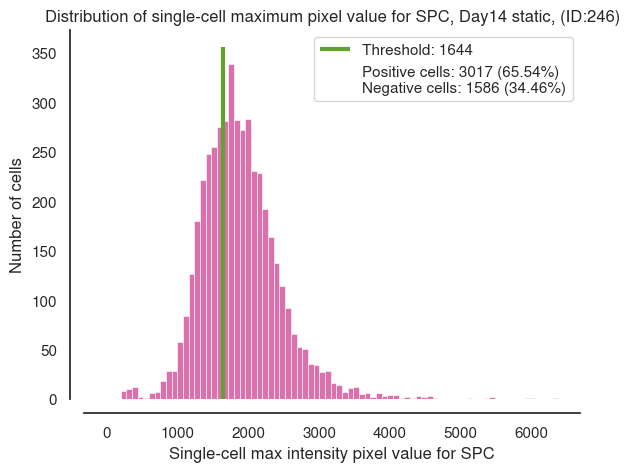

Number of channel PDPN positive cells, Day14 static, ID:246: 1775
Number of channel PDPN negative cells, Day14 static, ID:246: 2828


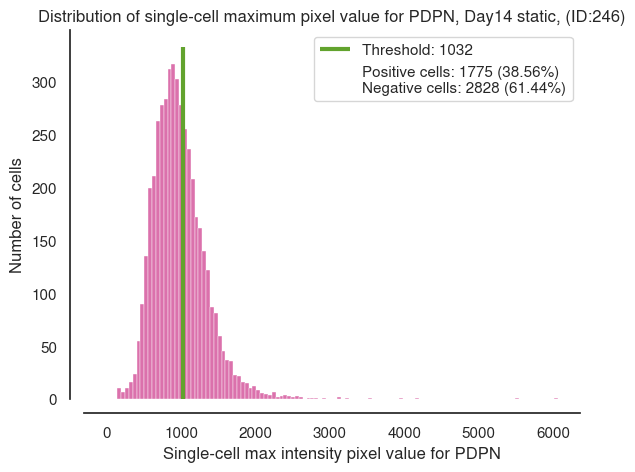

Number of channel SPC positive cells, Day7 breath, ID:196: 5643
Number of channel SPC negative cells, Day7 breath, ID:196: 312


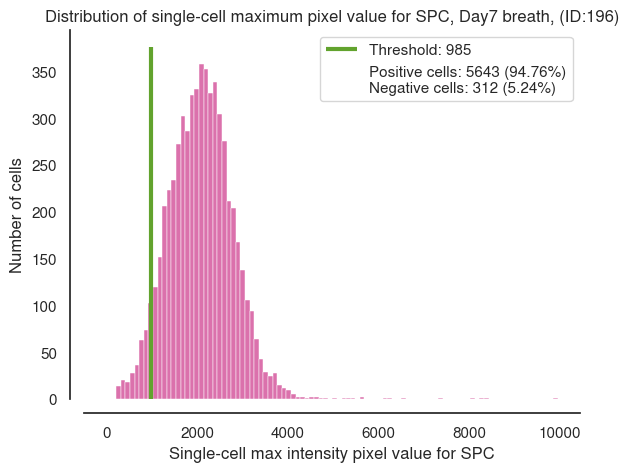

Number of channel PDPN positive cells, Day7 breath, ID:196: 2969
Number of channel PDPN negative cells, Day7 breath, ID:196: 2986


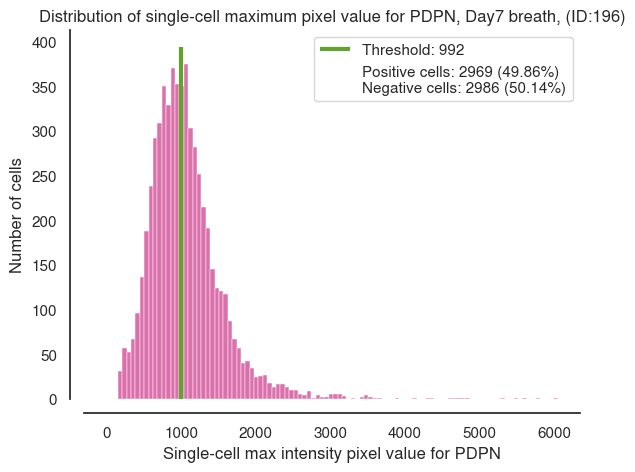

Number of channel SPC positive cells, Day7 static, ID:121: 4029
Number of channel SPC negative cells, Day7 static, ID:121: 897


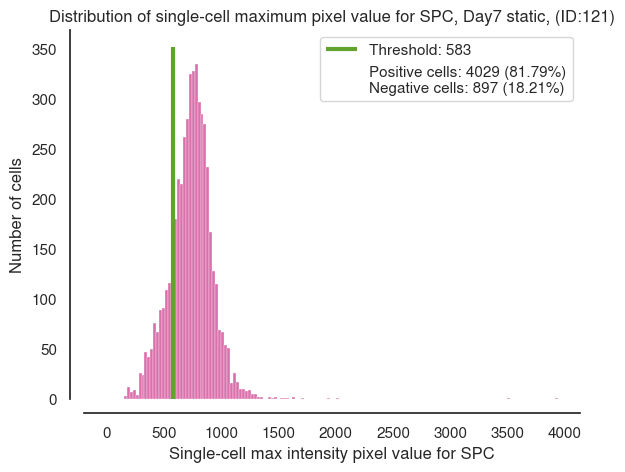

Number of channel PDPN positive cells, Day7 static, ID:121: 3674
Number of channel PDPN negative cells, Day7 static, ID:121: 1252


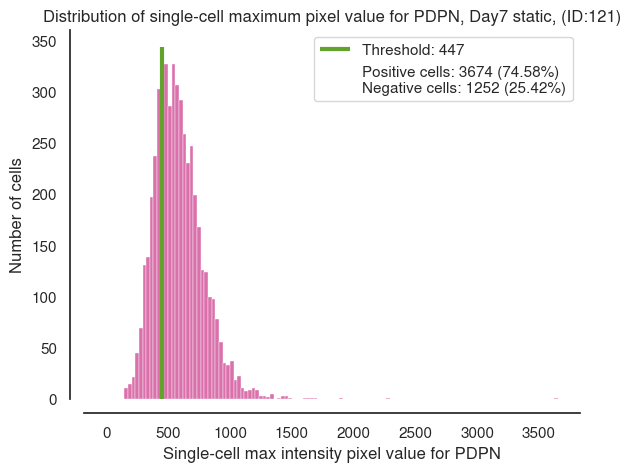

Number of channel NKX21 positive cells, Day14 breath, ID:286: 1032
Number of channel NKX21 negative cells, Day14 breath, ID:286: 1430


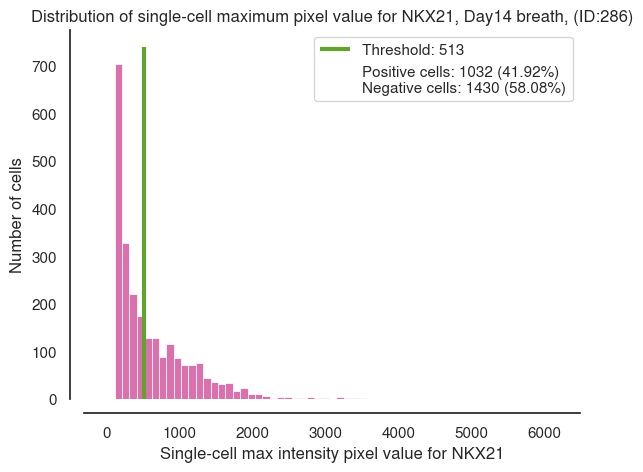

Number of channel NKX21 positive cells, Day14 static, ID:235: 846
Number of channel NKX21 negative cells, Day14 static, ID:235: 2494


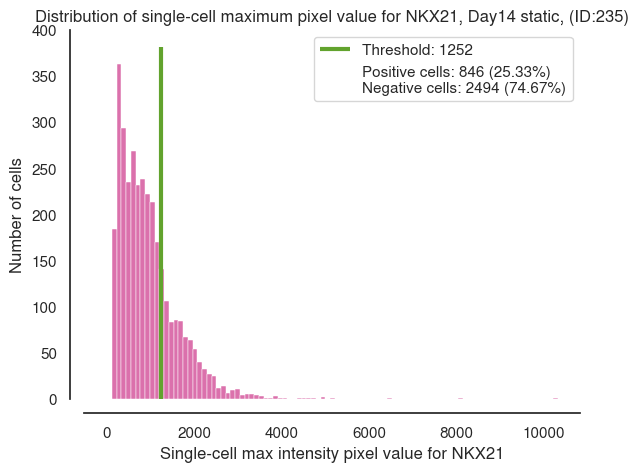

Number of channel NKX21 positive cells, Day7 static, ID:113: 2449
Number of channel NKX21 negative cells, Day7 static, ID:113: 1524


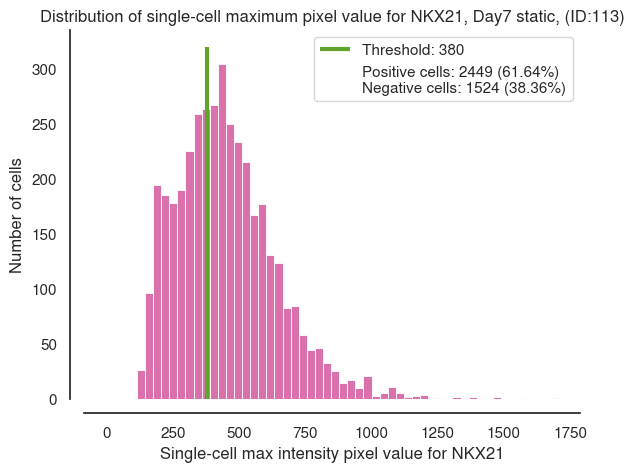

In [326]:
for job in tqdm(job1a_files):
    # get labels from job name
    image_id = job.split('_')[-1].replace('.tif', '')
    fn_details = job.split(local_rootdir)[-1]
    day_detail = fn_details.split('/')[1]
    day_label = day_detail.replace('_', ' ')
    # check tracks exist
    if image_id not in tracks_dict.keys():
        continue
    # pull tracks
    tracks = tracks_dict[image_id]
    # get list of channels
    channels = [ch for ch in job.split('/')[0].split('-')]
    # iterate over channels of interest
    for channel in [1,2]:
        # check we actually have the underlying data
        if (image_id, channels[channel]) not in threshold_dict.keys():
            continue
        threshold = threshold_dict[image_id, channels[channel]]
        n_positive = len([t for t in tracks if np.max(t.properties['mean_intensity'][:,channel]) >= threshold])
        n_negative = len([t for t in tracks if np.max(t.properties['mean_intensity'][:,channel]) < threshold])
        print(f'Number of channel {channels[channel]} positive cells, {day_label}, ID:{image_id}: {n_positive}')
        print(f'Number of channel {channels[channel]} negative cells, {day_label}, ID:{image_id}: {n_negative}')
        # plot histogram
        sc_intensities = [np.max(t.properties['mean_intensity'][:,channel]) for t in tracks]
        ax = sns.histplot(sc_intensities)
        plt.vlines(x=threshold,
                   ymax=ax.get_ylim()[-1],
                   ymin=ax.get_ylim()[0],
                   color=sns.color_palette('PiYG')[-1],  # my favorite colors :D
                   linewidth=3, 
                   label = f'Threshold: {threshold:.0f}')
        plt.vlines(x = 0,
                  ymin = 0, 
                  ymax = 0,  
                  color = 'white', 
                  linewidth=0, 
                  label = f'Positive cells: {n_positive} ({n_positive/(n_negative+n_positive)*100:.2f}%)\nNegative cells: {n_negative} ({n_negative/(n_negative+n_positive)*100:.2f}%)')
        sns.despine(offset = 10)
        plt.xlabel(f'Single-cell max intensity pixel value for {channels[channel]}')
        plt.ylabel('Number of cells')
        plt.legend()#['Threshold'], loc='lower right')
        plt.title(f'Distribution of single-cell maximum pixel value for {channels[channel]}, {day_label}, (ID:{image_id})')
        new_fn = f'ID:{image_id}_sc_expression_distribution_{channel}_{day}.pdf'
        file_path = os.path.join(local_rootdir, os.path.dirname(job), new_fn)
        plt.savefig(file_path, bbox_inches = 'tight', dpi = 314)
        plt.show()

In [196]:
channel = 1
n_positive = len([t for t in filtered_tracks if np.max(t.properties['mean_intensity'][:,channel]) >= threshold])
n_negative = len([t for t in filtered_tracks if np.max(t.properties['mean_intensity'][:,channel]) < threshold])
print(f'Number of channel {channel} positive cells: {n_positive}')
print(f'Number of channel {channel} negative cells: {n_negative}')
percentage = n_positive / (n_positive+n_negative) *100
print(f'Percentage of positive cells: {percentage:.2f}%')

Number of channel 1 positive cells: 3274
Number of channel 1 negative cells: 2465
Percentage of positive cells: 57.05%


#### Plot the number of cells either side of the threshold

Text(0.5, 1.0, 'Distribution of single-cell maximum pixel value for channel 1')

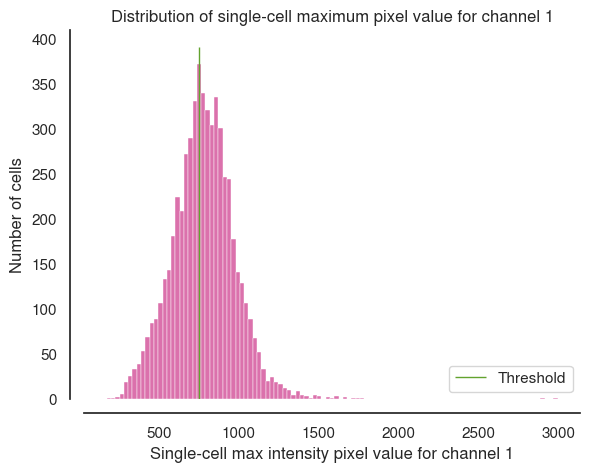

In [199]:
sc_intensities = [np.max(t.properties['mean_intensity'][:,channel]) for t in filtered_tracks]
ax = sns.histplot(sc_intensities)
plt.vlines(x=threshold,
           ymax=ax.get_ylim()[-1],
           ymin=ax.get_ylim()[0],
           color=sns.color_palette('PiYG')[-1],  # my favorite colors :D
           linewidth=1)
sns.despine(offset = 10)
plt.xlabel(f'Single-cell max intensity pixel value for channel {channel}')
plt.ylabel('Number of cells')
plt.legend(['Threshold'], loc='lower right')
plt.title(f'Distribution of single-cell maximum pixel value for channel {channel}')